In [1]:
import pandas as pd
import numpy as np

def load_open_prices_twse(path: str) -> pd.DataFrame:
    """
    Reads a long-format TWSE parquet with columns at least:
    ['stock_id', 'date', 'open', ...]
    Returns a wide DataFrame: index=date, columns=stock_id, values=open.
    """
    df = pd.read_parquet(path)
    required = ["stock_id", "date", "open"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"Missing columns {missing}. Found: {df.columns.tolist()}")

    df["date"] = pd.to_datetime(df["date"]).dt.date
    open_px = (
        df.pivot_table(index="date", columns="stock_id", values="open", aggfunc="first")
        .sort_index()
    )
    open_px.index.name = "date"
    open_px = open_px.apply(pd.to_numeric, errors="coerce")
    open_px = open_px.dropna(how="all")

    return open_px   # ← 這是關鍵


In [2]:
open_px = load_open_prices_twse("../data/twse_2025.parquet")  # adjust path if needed


In [3]:
def momentum_factor_from_open(
    open_px: pd.DataFrame,
    lookback: int = 5,
    gap: int = 1,
    zscore_by_day: bool = True,
    clip: float = 5.0
) -> pd.DataFrame:
    """
    Open-to-open momentum:
      raw = ln( P_{t-gap} / P_{t-gap-lookback} )
    Example: lookback=5, gap=1 => uses info up to t-1 for a signal at t.

    Returns a DataFrame aligned to open_px (index=date, columns=asset).
    """
    px_recent = open_px.shift(gap)
    px_past   = open_px.shift(gap + lookback)
    raw = np.log(px_recent) - np.log(px_past)

    if zscore_by_day:
        mean_ = raw.mean(axis=1)
        std_  = raw.std(axis=1).replace(0, np.nan)
        factor = raw.sub(mean_, axis=0).div(std_, axis=0)
        if clip is not None:
            factor = factor.clip(-clip, clip)
    else:
        factor = raw

    factor = factor.dropna(how="all")
    factor.index.name = "date"
    return factor

# build 5D momentum (t uses up to t-1 data)
factor_df = momentum_factor_from_open(open_px, lookback=5, gap=1)
factor_df.tail()


stock_id,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9939,9940,9941,9942,9943,9944,9945,9946,9955,9958
date,,,,,,,,,,,,,,,,,,,,,
2025-09-01,-0.763430,-0.708872,-0.464440,-0.344541,-0.605913,-0.344541,-0.529372,-0.292937,-0.200647,-0.434549,...,-0.286428,-0.578502,-0.571144,-0.197268,-0.344541,-0.439124,-0.425919,-1.063263,0.533491,-0.804726
2025-09-02,-0.904194,-0.706392,-0.364909,-0.346386,-0.287369,-0.180603,-0.512892,-0.392083,-0.015650,-0.397039,...,-0.417098,-0.248907,-0.412390,-0.105795,-0.205464,-0.033543,-0.016742,-1.527900,0.598843,-1.765019
2025-09-03,-0.697808,-0.775605,-0.234223,-0.453893,-0.149511,0.302564,-0.392269,-0.034035,0.078162,-0.200389,...,-0.551399,-0.108132,-2.149374,0.210131,-0.195457,-0.086570,-0.093312,-1.491329,0.991303,-1.284175
2025-09-04,-0.523997,-0.322245,-0.018917,-0.548439,0.073356,0.382360,0.143653,0.198988,0.736739,0.307633,...,-0.507481,0.279173,-1.992208,0.198988,0.082289,0.198988,0.394111,-1.784560,1.968243,-0.915417
2025-09-05,-0.410858,-0.323624,-0.133988,-0.081283,0.249956,0.244314,0.175636,0.071386,0.117631,-0.099278,...,-0.733619,0.147244,-1.431375,-0.093718,-0.038849,0.017490,0.591362,-0.628463,1.278796,-1.624615


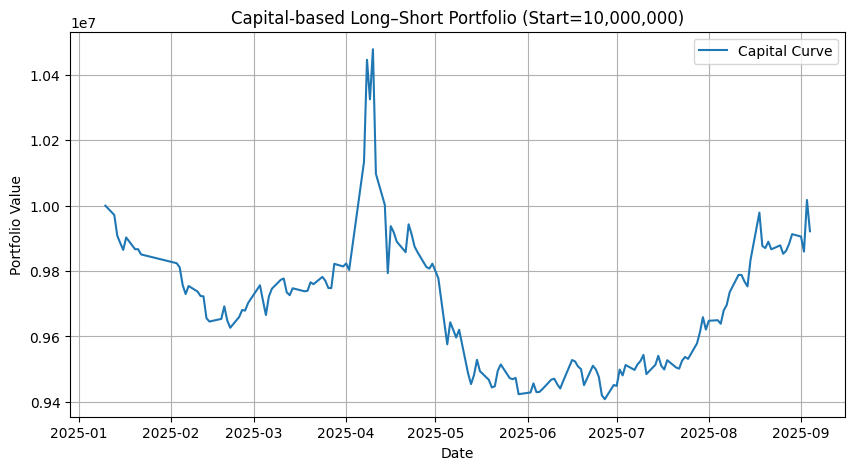

Performance Stats:
FinalCapital: 9,921,878
AnnReturn: -0.0124
AnnVol: 0.1087
Sharpe: -0.0618
MaxDD: -0.1022


In [11]:
import sys
import os

# 假設你的專案結構是：
# long_short_portfolio2/
# ├── core/
# └── notebooks/test_factor.ipynb
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from core.backtester import run_capital_backtest

res = run_capital_backtest(
    factor=factor_df,
    open_px=open_px,
    initial_capital=10_000_000,
    long_frac=0.1,
    short_frac=0.1,
    cost_rate=0.0,
)



